<a href="https://colab.research.google.com/github/Vernalhav/numeric_methods/blob/master/numerico_aplicacoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Victor Giovannoni Vernalha 10786159  
Victor Graciano de Souza Correia 10431201

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# **Tema 1: Resolução de Sistemas Lineares**

## Revisão Teórica (TODO)

Um sistema linear de ordem $n$ pode ser escrito como
$$Ax = b \quad A \in \mathbb{M}_n(\mathbb{R}) \; x, b \in \mathbb{R}^n$$
com $A, b$ dados. O objetivo do sistema é encontrar o vetor $x$ tal que a igualdade seja satisfeita.  
  
Existem algoritmos para solucionar esses sistemas, e eles são divididos em duas grandes categorias: os métodos diretos e os métodos iterativos. Os métodos diretos encontram a solução numérica de maneira "exata" (descontando erros de arredondamento inerentes às operações computacionais). Os métodos iterativos, quando convergem, encontram uma solução que pode ser arbitrariamente próxima da solução real.  
  
Nessa aplicação, decidimos comparar os métodos de Eliminação de Gauss e o método Gauss-Seidel.  
A eliminação de Gauss consiste em escalonar a matriz $A$ e o vetor $b$ de modo que $A$ fique diagonal superior e o sistema seja equivalente, para que seja solucionado por substituições trivialmente.  
  
O método Gauss-Seidel consiste em encontrar ??

## Implementação

### Funções Auxiliares

In [3]:
import time


def timeit(f):
    '''
    Decorator that times a function
    execution speed and returns a tuple
    with the elapsed time and the function
    return value(s).
    '''

    def time_f(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        return time.time() - start, result

    return time_f

In [4]:
def get_matrix(n, matrix_type):
    '''
    Returns a matrix with dimension n x n

    matrix_type can be either
        'diag dominant' : Diagonally dominant (Gauss-Seidel always converges)
        'SPD'           : Symetrically Positive Definite
        'Semi SPD'      : Symetrucally Positive Semi-Definite
        'random'        : Random elements

    '''
    A = np.random.rand(n, n)

    if (matrix_type == 'Semi SPD'): return np.dot(A, A.T)

    if (matrix_type == 'SPD'): return np.dot(np.tril(A), np.tril(A).T)

    if (matrix_type == 'random'): return A

    if (matrix_type == 'diag dominant'):
        for i in range(n):
            A[i, i] += np.sum(np.abs(A[i, :]))
        return A

In [5]:
INF = 2**32

def absolute_error(v1, v2):
    error = np.linalg.norm(v1 - v2)
    return error if not np.isnan(error) else INF


def gauss_seidel_convergence(A):
    '''
    Returns boolean indicating whether or
    not Gauss-Seidel converges with A
    '''
    n = A.shape[0]
    beta = np.zeros((n, 1))
    beta[0] = np.sum(np.abs(A[0, 1:]))/np.abs(A[0, 0])
    if beta[0] >= 1: return False

    for i in range(1, n):
        # Since beta is initialized as 0, we can
        # do the dot product without worrying
        # about the row slice
        beta[i] = (np.dot(np.abs(A[i,:]), beta) +
                  np.sum(np.abs(A[i, i+1:])))/np.abs(A[i, i])
        if beta[i] >= 1: return False

    return True

In [6]:
def get_range(start, end):
    ''' Returns increasing np range if start < end, or decreasing if end < start '''
    if start <= end:
        return np.arange(start, end, 1)
    else:
        return np.arange(start, end, -1)


def check_triangular(A):
    ''' Checks if A is upper or lower triangular, or neither '''
    if np.allclose(A, np.tril(A)): return 'lower'
    if np.allclose(A, np.triu(A)): return 'upper'
    if np.allclose(A, np.diag(np.diag(A))): return 'diagonal'    
    return 'neither'

In [7]:
def substitution(T, b):
    '''
    Given T a triangular matrix,
    solves Tx = b. Returns x.
    Throws ValueError if matrix
    is invalid.
    '''

    n = T.shape[0]
    start, end = 0, n

    matrix_type = check_triangular(T)
    if matrix_type == 'upper':
        # Sets up indices for regressive substitution
        start, end = n - 1, -1
    if matrix_type == 'neither':
        raise ValueError('Matrix must be either upper or lower triangular')

    x = np.zeros((n, 1))
    for i in get_range(start, end):
        result = 0
        for j in get_range(start, i):
            result += T[i][j]*x[j]
        x[i] = (b[i] - result)/T[i][i]

    return x

### Solução de sistemas por eliminação de Gauss


In [8]:
@timeit
def gauss_elimination(A, b):
    '''
    Solves Ax = b using Gauss Elimination.
    Returns array x and doesn't change
    either A or b
    '''

    A = np.array(A, dtype=float)
    b = np.array(b)

    m, n = A.shape

    for cur_line in range(n-1):
        # Find the k-th pivot
        p = np.argmax(np.abs(A[cur_line : , cur_line])) + cur_line

        # Swap lines in matrix and solution vector
        A[[cur_line, p]] = A[[p, cur_line]]
        b[[cur_line, p]] = b[[p, cur_line]]

        for cur_col in range(cur_line + 1, n):
            m = -A[cur_col, cur_line]/A[cur_line, cur_line]
            A[cur_col, cur_line : ] = A[cur_col, cur_line : ] + m*A[cur_line, cur_line : ]
            b[cur_col] += m*b[cur_line]

    return substitution(A, b)

### Solução de sistemas por Gauss-Seidel

In [9]:
EPSILON = 1e-6
MAX_ITERATIONS = 1000

@timeit
def gauss_seidel(A, b, tol=EPSILON, max_iterations=MAX_ITERATIONS, return_error=False):
    '''
    Given a real matrix A and an array b, solve for x
    iteratively until relative error < tol or number
    of iterations exceeds the max.

    if return_error is true, returns (x, error)
    '''
    A = np.array(A)
    n = A.shape[0]

    L_inv = np.linalg.inv(np.tril(A))
    R = np.triu(A, k=1)

    C = np.dot(-L_inv, R)
    g = np.dot(L_inv, b)

    x = np.zeros((n, 1))
    x_prev = np.zeros((n, 1))

    iterations = 0
    error = tol + 1 # Just to guarantee the first iteration

    while iterations < max_iterations and error > tol:
        x = np.dot(C, x_prev) + g
        
        iterations += 1
        error = absolute_error(np.dot(A, x), b)
        x_prev = x
        
    if return_error: return x, error
    return x

## Aplicação

In [10]:
def return_info(max_n=2**9, max_iterations=1e3, tol=1e-6, matrix_type='diag dominant'):
    '''
    Compares Gauss-Seidel and Gauss Elimination
    using matrices of size 16 to max_n, multiplied
    by 2 each time.

    matrix_type can be either
        'diag dominant' : Diagonally dominant (Gauss-Seidel always converges)
        'SPD'           : Symetrically-Positive-Definite
        'random'        : Random elements
    '''

    info = {
        'n': [],
        'gauss-elimination': {
            'times': [],
        },
        'gauss-seidel': {
            'times': [],
            'errors': []
        }
    }

    n = 16
    while n <= max_n:
        A = get_matrix(n, matrix_type)
        b = np.random.rand(n, 1)

        info['n'].append(n)

        # print(f'Testing Gauss elimination with n = {n}')
        duration, x = gauss_elimination(A, b)
        info['gauss-elimination']['times'].append(duration)

        # print(f'Testing Gauss-Seidel with n = {n}')
        duration, (x, error) = gauss_seidel(A, b, tol=tol, max_iterations=max_iterations, return_error=True)
        info['gauss-seidel']['times'].append(duration)
        info['gauss-seidel']['errors'].append(error)

        n *= 2
    
    return info

In [11]:
def compare_methods(max_n=2**9, max_iterations=1e3, tol=1e-3, matrix_type='diag dominant'):
    '''
    Plots the data collected from the comparison
    of the two methods.

    max_n represents the maximum dimension of the square matrix
    max_iterations represents the max number of iterations for Gauss-Seidel
    tol is the absolute residual tolerance for Gauss-Seidel
    matrix_type can be either
        'diag dominant' : Diagonally dominant (Gauss-Seidel always converges)
        'SPD'           : Symetrically-Positive-Definite
        'random'        : Random elements
    '''
    info = return_info(max_n, max_iterations, tol, matrix_type)

    fig, ax = plt.subplots()
    ax.set_xscale('log', basex=2)

    Ns = info['n']
    elimination_times = info['gauss-elimination']['times']
    seidel_times = info['gauss-seidel']['times']
    seidel_errors = info['gauss-seidel']['errors']

    ax.plot(Ns, elimination_times, label='Gaussian Elimination Time')
    ax.plot(Ns, seidel_times, label='Gauss-Seidel Time')

    ax2 = ax.twinx()

    colormap = np.where(np.array(seidel_errors) < tol, 'b', 'r')
    ax2.scatter(Ns, seidel_errors, label='Gauss-Seidel Errors', marker='o', color=colormap)

    ax.set_ylim((0, 1 + min(60, max(max(seidel_times), max(elimination_times)))))

    ax.set_ylabel('Time (s)')
    ax.set_xlabel('N')
    ax2.set_ylabel('Absolute Residual Error')

    ax.legend(loc='upper left', fontsize='medium', bbox_to_anchor=(1.2, 1))
    ax2.legend(loc='upper left', fontsize='medium', bbox_to_anchor=(1.2, 0.8))

    plt.show()

---

Nesse exemplo, geramos matrizes dominantes diagonais para que o método de Gauss-Seidel sempre convergisse. Podemos ver que nessa circunstância, o Gauss-Seidel é a melhor opção, já que é muito mais rápido que a eliminação de Gauss e converge para todos os valores de $n$ com um erro dentro da tolerância.

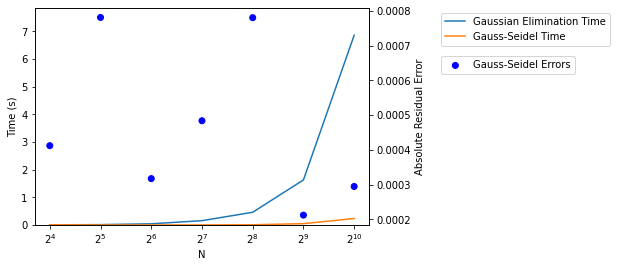

In [12]:
compare_methods(max_n=2**10, matrix_type='diag dominant')

---

Nesse exemplo, geramos matrizes Simétricas Positivas Semi-Definidas $(x^TMx \geq 0 \quad \forall\; x \in \mathbb{R}^n)$ multiplicando uma matriz aleatória por sua transposta. Nesse caso, ficam bem mais visíveis as deficiências do Gauss-Seidel. Com $10^4$ iterações, o tempo de execução dos dois métodos é muito semelhante, embora o Gauss-Seidel tenha convergido em nenhum caso (mesmo com a tolerância razoavelmente alta). Os erros exibidos, no entanto, são "pequenos", indicando que o método talvez fosse convergir se aumentássemos as iterações, mas definitivamente a eliminação de Gauss é a melhor opção, já que o seu resultado é "exato" (obtido diretamente) e tem um tempo de execução melhor.

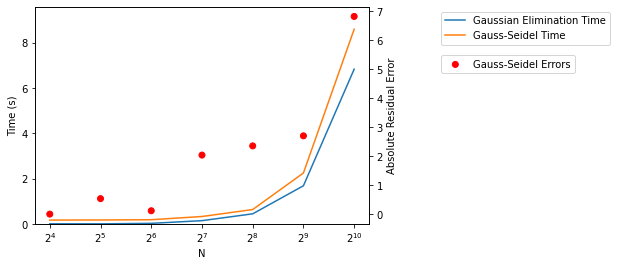

In [13]:
# Red dots indicate that Gauss-Seidel has not converged fot that matrix size.
compare_methods(max_n=2**10, matrix_type='Semi SPD', max_iterations=1e4, tol=1e-3)

---

Nesse exemplo, geramos matrizes aleatórias. Podemos ver que o método de Gauss-Seidel não converge, tendo erros "infinitos" (representados por $2^{32}$).

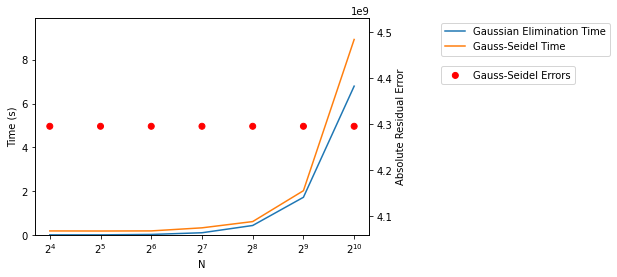

In [14]:
compare_methods(max_n=2**10, matrix_type='random', max_iterations=1e4, tol=1e-3)

---

# **Tema 2: Interpolação polinomial**

## Revisão teórica

O objetivo da interpolação polinomial é dado $n+1$ pontos $P_0, P_1, \dots P_n$, encontrar uma função polinomial $P(x)$ de grau $n$ que passe por todos os pontos dados.  
  
Optamos chegar nesse resultado através do polinômio no formato de Lagrange, já que a explicação é mais intuitiva e a implementação mais simples.  
  
Queremos encontrar um polinômio da forma $$P(x) = \sum_{k=0}^{n} y_kl_k(x)$$
Onde $l_k(x)$ é um polinômio que só depende da coordenada $x$ dos pontos dados e $y_k$ é a k-ésima coordenada $y$ dos pontos dados.  

Se o k-ésimo ponto tem coordenadas $(x_k, y_k)$, sabemos que $P(x_k) = y_k$, já que queremos que o polinômio passe por todos os pontos dados.  
Observe que uma maneira dessa condição ser atendida é para que todos os polinômios $\ l_i(x_k) = 0$ quando $i \neq k\ $ e $\ l_k(x_k) = 1$, já que o somatório iria resultar em exatamente $y_k$.  
Mas se $\ i \neq k \implies l_k(x_i) = 0$, então o conjunto $\{ x_0, \dots, x_{k-1}, x_{k+1}, \dots, x_n \}$ correspondem às raízes de $l_k(x)$.  
  
Podemos então escrever

$$ \quad l_k(x) = \alpha\prod_{\substack{i=0\\i \neq k}}^{n}(x - x_i) \tag{$\star$} $$

Observe que, de fato, o conjunto de raízes que definimos acima é satisfeito para esse polinômio. O fator $\alpha$ é necessário para representar todos os polinômios que possuem essas raízes. Para encontrar $\alpha$, basta utilizar o fato de que $l_k(x_k)=1$. Avaliando $l_k(x_k)$, temos:

$$1 = \alpha \prod_{\substack{i=0\\i \neq k}}^{n}(x_k-x_i),$$

logo

$$ \alpha = \prod_{\substack{i=0 \\ i \neq k}}^{n}(x_k - x_i)^{-1} $$
  
Portanto, substituindo $\alpha$ em $(\star)$, o nosso polinômio $l_k(x)$ é

$$l_k(x) = \prod_{\substack{i=0 \\ i \neq k}}^{n}\frac{(x - x_i)}{(x_k - x_i)}$$

  
Uma vez que definimos todos os $l_k(x)$, podemos construir $P(x)$.

## Implementação

In [15]:
def k_lagrange_polynomial(k, X):
    """
    Return the k-th lagrange polynomial as a function.
    It receives x as input and returns L_k(x)
    """
    x_k = X[k]
    X_new = np.delete(X, k)

    def k_polynomial(x):
        return np.prod((x - X_new)/(x_k - X_new))
    
    return k_polynomial

In [16]:
def lagrange_polynomial(X, Y, return_Ls=False):
    """
    Returns the polynomial that fits the given points X/Y
    as a function.
    The returned function receives x as input and returns
    P(x).

    If retuen_Ls is True, then this function returns a tuple
    with the first element being P(x) and the second is an
    array with all the L_k polynomials used to compute P(x).
    """

    X = np.array(X)
    Y = np.array(Y)
    n = X.shape[0]
    
    L = [ k_lagrange_polynomial(k, X) for k in range(n) ]

    def polynomial(x):
        L_x = np.array([ L[k](x) for k in range(n) ])
        return np.dot(Y, L_x)

    if return_Ls: return polynomial, L
    
    return polynomial

## Aplicação: aproximação de funções por _sampling_

In [17]:
def approximate(points, x_0, show_Ls=True, show_axis=False):
    """
    Approximate a value P(x_0) given a set of points by
    fitting a polynomial through them. 
    
    Returns P(x_0), where P(x) is the lagrange polynomial
    that fits the given points and displays the computed
    polynomial.

    If show_Ls is false, do not display the L polynomials
    that were used to compute P(x). If it is true, display
    y_k*l_k(x)

    If show_axis is true, display the x axis.
    """

    X = [points[i][0] for i in range(len(points))]
    Y = [points[i][1] for i in range(len(points))]

    P, L = lagrange_polynomial(X, Y, return_Ls=True)
    
    min_x = min(X)
    max_x = max(X)

    avg_x_dist = (min_x + max_x + 1)/(2*len(X))

    # x coordinates to evaluate P(x) in
    x = np.linspace(min(x_0, min_x) - avg_x_dist, max(x_0, max(X)) + avg_x_dist, 10*len(X))

    plt.plot(x, [P(x_i) for x_i in x])  # Plot P(x)
    plt.scatter(X, Y, marker='o')       # Mark given points

    plt.scatter(x_0, P(x_0), marker='o', color='red')   # Mark x_0/P(x_0)

    if show_axis: plt.plot([x[0], x[-1]], [0, 0], color='black') # Plot x axis

    if not show_Ls:
        plt.show()
        return P(x_0)

    for i in range(len(L)):
        # Plot y_i*L_k(x)
        plt.plot(x, [Y[i]*L[i](x_i) for x_i in x], linestyle='--', alpha=0.7)

    plt.show()
    return P(x_0)

Algo interessante de se visualizar é que o polinômio $y_kl_k(x)$ gerado por cada $x_k$ se intersecta com a curva final no ponto $(x_k, y_k)$ por conta da restrição que impusemos:  $l_k(x_k) = 1$. Além disso, o polinômio é 0 para os outros pontos fornecidos por conta da outra restrição que impusemos com relação às suas raízes.

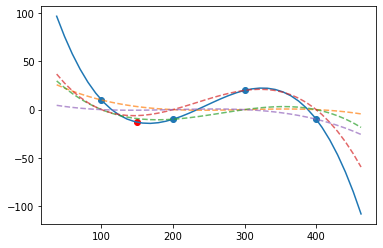

An approximation for f(150) is -13.12


In [18]:
points = [(100, 10), (200, -10), (300, 20), (400, -10)]
x_0 = 150

approx = approximate(points, x_0)
print('An approximation for f({}) is {:.2f}'.format(x_0, approx))

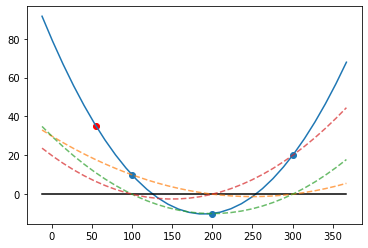

An approximation for f(55) is 35.31


In [19]:
x_0 = 55
points = [(100, 10), (200, -10), (300, 20)]

approx = approximate(points, x_0, show_axis=True)
print('An approximation for f({}) is {:.2f}'.format(x_0, approx))

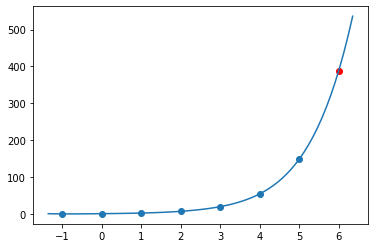

An approximation for f(6) is 387.16


In [20]:
points = [(x, np.exp(x)) for x in range(-1, 6)]
x_0 = 6

approx = approximate(points, x_0, show_axis=False, show_Ls=False)
print('An approximation for f({}) is {:.2f}'.format(x_0, approx))

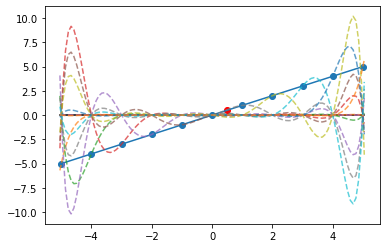

An approximation for f(0.5) is 0.50


In [21]:
points = [(x, x) for x in range(-5, 6)]
x_0 = 0.5

approx = approximate(points, x_0, show_axis=True)
print('An approximation for f({}) is {:.2f}'.format(x_0, approx))

# **Tema 3: Regressão Linear**

## Revisão Teórica (TODO)

## Implementação

## Aplicação

# **Tema 4: Solução Numérica de EDOs ou Autovalores**

## Revisão Teórica (TODO)

## Implementação

In [22]:
EPSILON = 1e-6
MAX_ITERATIONS = 1000


def non_diagonal_error(B):
    '''
    Return absolute max value of
    B outside the main diagonal
    '''
    mask = np.ones(B.shape, dtype=bool)
    np.fill_diagonal(mask, 0)     # Mask is true in all indices except diagonal
    return np.abs(B)[mask].max()  # Return abs max element of the masked matrix



def francis(B, tol=EPSILON, max_iterations=MAX_ITERATIONS, print_error=False):
    '''
    Givan B symmetric square matrix,
    returns a tuple with B's eigenvectors as
    the first element and their eigenvalues as
    the second element.
    The eigenvectors are returned as a matrix
    where the columns of the matrix are the
    eigenvectors. (n x n)

    NOTE: all values are an approxumation with
          tolerance 'tol'
    '''
    if B.shape[0] != B.shape[1]: raise ValueError("Matrix must be square!")

    iterations = 0
    n = B.shape[0]
    B_k, V = B, np.eye(n)   # Initialize V as identity for first dot protuct

    while iterations < max_iterations and non_diagonal_error(B_k) > tol:
        Q, R = np.linalg.qr(B_k)
        B_k = np.dot(R, Q)
        V = np.dot(V, Q)
        iterations += 1

    eigenvalues = np.diag(B_k)
    eigenvectors = V

    if (iterations >= max_iterations): print('Method exceeded max iterations. Might not have converged.')

    if print_error: print('Took {} iterations with off-diagonal error {}'.format(iterations, non_diagonal_error(B_k)))
    return eigenvectors, eigenvalues

In [23]:
def truncated_svd(A, tol=1e-4, max_iterations=1e3):
    '''
    Find truncated SVD decomposition of A.
    Find matrices such that A = U*S*V^T, where
        A is m x n
        U is m, min(m, n)
        S is a diagonal matrix of min(m, n) x min(m, n)
        V^T is min(m, n), n
    
    Returns tuple with (U, np.diag(S), V^Y)
    '''
    A = np.array(A)
    m, n = A.shape
    min_dim = min(m, n)

    V, eigenvalues = francis(np.dot(A.T, A), tol=tol, max_iterations=max_iterations)
    singular_vals = np.sqrt(eigenvalues[:min_dim])   # Truncate singular values

    V = V[:, :min_dim] # Truncate V

    U = np.dot(np.dot(A, V), np.diag(1/singular_vals))

    return U, singular_vals, V.T

## Aplicação: Compressão de Imagens

In [24]:
A = np.array([
              [0, 1, 2, 3, 4],
              [4, 3, 2, -1, -10],
              [0, 10, 0, -1, 0],
              [1, 1, 1, -2, 40]])

for i in range(100):
    U, S, V = truncated_svd(A)
    U_, S_, V_ = np.linalg.svd(A, full_matrices=False)

    assert np.allclose(np.dot(np.dot(U, np.diag(S)), V), A)
    assert np.allclose(S, S_)

    A = np.random.rand(7, 15)

In [41]:
import imageio


def mean_channel_error(img1, img2):
    n_bytes = img1.shape[0] * img1.shape[1] * (1 if len(img1.shape) < 3 else img1.shape[2])
    total_value = np.abs(np.sum(img1 - img2))

    return total_value/n_bytes


def normalize(img):
    '''
    Return img normalized to interval [0, 255] as
    an integer matrix
    '''
    return ((img - img.min())*\
            (255/(img.max()-img.min()))).astype('uint8')


def grayscale(img):
    img_gray = np.zeros(img.shape[:2])
    img_gray += img[:,:,0]
    img_gray += img[:,:,1]
    img_gray += img[:,:,2]

    img_gray *= 255.0/img_gray.max()
    return img_gray


def compress(img, modes, return_matrices=False):

    channel_matrices = []

    m, n = img.shape[:2]
    if len(img.shape) < 3: img = img.reshape((m, n, 1))

    img_compressed = np.zeros(img.shape)

    for channel in range(img.shape[2]):
        U, s, Vh = np.linalg.svd(img[:,:,channel], full_matrices=False)

        U_prime = U[:, :modes]
        s_prime = s[:modes]
        Vh_prime = Vh[:modes, :]

        channel_matrices.append((U_prime, s_prime, Vh_prime))

        compressed_channel = np.dot(np.dot(U_prime, np.diag(s_prime)), Vh_prime)
        img_compressed[:,:,channel] = compressed_channel

    img_compressed = normalize(img_compressed)

    if return_matrices: return channel_matrices
    return img_compressed

In [42]:
def visualize_compression(img_url, initial_mode=1, modes_step=6, n_rows=2, make_grayscale=False):

    if make_grayscale: img = grayscale(imageio.imread(img_url))
    else: img = imageio.imread(img_url)

    m, n = img.shape[:2]

    channels = 1
    if len(img.shape) >= 3: channels = img.shape[2]

    img = img.reshape((m, n, channels))
    original_img_size = channels*m*n/1000

    N_COLS = 3
    fig, axs = plt.subplots(n_rows+1, N_COLS, figsize=(20, 4*(n_rows + 1)))

    x_modes = []
    sizes = []
    errors = []

    modes = initial_mode
    for i, ax in enumerate(axs.flat):
        if i >= n_rows*N_COLS: break
        
        ax.set_yticks([])
        ax.set_xticks([])

        x_modes.append(modes)
        size = min(channels*modes*(m + n + modes)/1000, original_img_size)
        sizes.append(100*size/original_img_size)

        compressed_img = compress(img, modes)
        errors.append(mean_channel_error(img, compressed_img))

        if channels == 1: compressed_img = compressed_img.reshape((m, n))

        ax.imshow(compressed_img, cmap='gray')
        ax.set_title(f'{modes} modes ({size} Kb)')

        modes += modes_step

    error_ax = plt.subplot(n_rows + 1, 2, 2*n_rows + 2)
    error_ax.set_xlabel('Number of Singular Values used in compression')
    size_ax = error_ax.twinx()

    error_ax.plot(x_modes, errors, color='red')
    error_ax.set_ylabel('Mean Channel Error\n(Red)')

    size_ax.plot(x_modes, sizes)
    size_ax.set_ylim((0, 100))
    size_ax.set_ylabel('Relative size to original Image (%)\n(Blue)')

    og_img_ax = plt.subplot(n_rows + 1, 2, 2*n_rows + 1)
    og_img_ax.set_yticks([])
    og_img_ax.set_xticks([])
    og_img_ax.set_title(f'Original Image ({original_img_size} Kb)')

    if channels == 1: img = img.reshape((m, n))
    og_img_ax.imshow(img, cmap='gray')

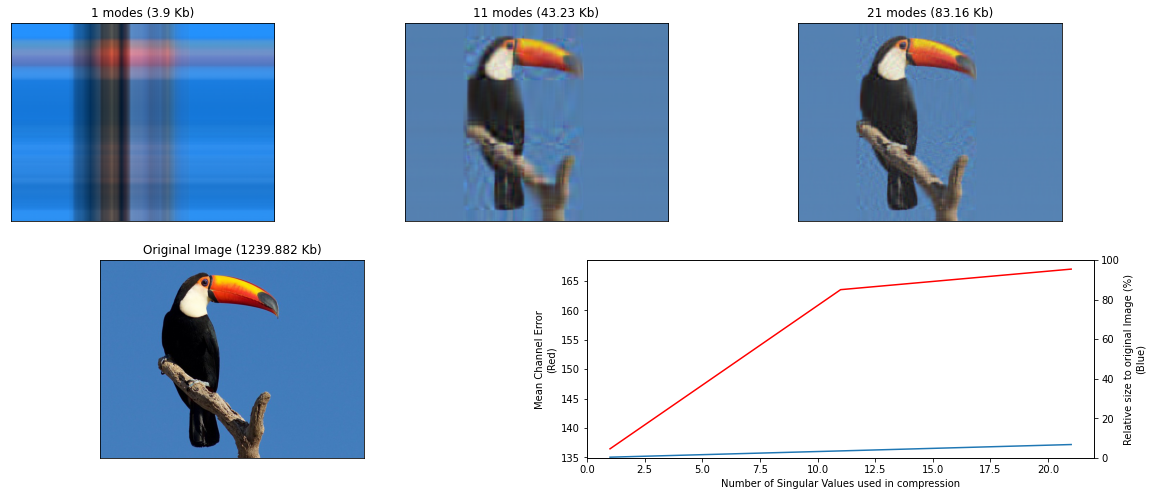

In [45]:
toucan_url = 'https://test.cdn.download.ams.birds.cornell.edu/api/v1/asset/96276931/900'
text_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSR6D37wLrtEzTLszyF4TPKkz6T91tp96TIxQ&usqp=CAU'

visualize_compression(toucan_url, initial_mode=1, n_rows=1, modes_step=10, make_grayscale=False)